In [27]:
import os
import pickle
import random as rn
import warnings
from multiprocessing import cpu_count

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from gensim.models import Word2Vec
from IPython.display import display
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, average_precision_score, \
    ndcg_score, label_ranking_average_precision_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant, GlorotUniform
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Conv1D, \
    GlobalMaxPooling1D, SpatialDropout1D, LSTM, GRU, Flatten, MaxPooling1D, \
    BatchNormalization, ReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import data
import preprocessing

seed = 42
sns.set()

def reset_seed():
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    np.random.seed(seed)
    rn.seed(seed)
    tf.random.set_seed(seed)

## Extracting the data

In [2]:
# data.extract_data(extraction_dir="train", data_dir="data", data_zip_name="reuters-training-corpus.zip")

train_df = pd.read_pickle("train/data.pkl")

# train_df = data.get_docs_labels("train/REUTERS_CORPUS_2")
# train_df.to_pickle("train/data.pkl")

train_docs = train_df["doc"].values
train_labels = np.array(train_df["labels"].tolist())
n_labels = len(data.CODEMAP)

print(train_docs.shape)
print(train_labels.shape)
print(train_docs[2])
print(train_labels[2])

(299773,)
(299773, 126)
Toronto stocks end higher after volatile session. CHANGE				    CHANGE TSE	  5900.37    +50.15   HI 5900.37	    LO  5840.29 DJI	  6611.05    +27.57   GOLD (LONDON)   US$350.00 +1.90 FTSE100    4248.10    -64.80   GOLD (NY-COMEX) US$354.80 +0.70 NIKKEI    17869.59   -133.81   LME CASH NICKEL US$7659   +99.0 CANDLR	1.3883		 LME CASH ALUM   US$1602.0  -4.0 CAN 30-YR   107.41     -0.15   BRENT CRUDE     US$19.09  -0.27 --------------------MARKET COMMENT---------------------------- * Toronto stocks ended higher on Tuesday, buoyed by strength in golds and banking * Computer problems due to heavy trading in Bre-X Minerals hampered session * 84 million shares traded Toronto's key stock index ended higher on Tuesday as the saga of Bre-X Minerals Ltd and its Indonesian gold find continued to dominate Canada's biggest stock market. The TSE 300 Index climbed 50.15 points to close at 5900.37 in heavy turnover of 84.07 million shares worth C$1.4 billion. But the overall marke

## Preprocessing the documents

In [3]:
with open("train/preprocessed_docs_lemmatized_no_sw.pkl", "rb") as f:
    preprocessed_train_docs = pickle.load(f)

# preprocessed_train_docs = preprocessing.preprocess_corpus(train_docs)
# with open("train/preprocessed_docs.pkl", "wb") as f:
#     pickle.dump(preprocessed_train_docs, f)

print(preprocessed_train_docs[2])

toronto stock end high volatile session change change tse 5900.37 +50.15 hi 5900.37 lo 5840.29 dji 6611.05 +27.57 gold london us$ 350.00 +1.90 ftse100 4248.10 -64.80 gold ny comex us$ 354.80 +0.70 nikkei 17869.59 -133.81 lme cash nickel us$ 7659 +99.0 candlr 1.3883 lme cash alum us$ 1602.0 -4.0 30-yr 107.41 -0.15 brent crude us$ 19.09 -0.27 --------------------market comment---------------------------- toronto stock end higher tuesday buoy strength gold banking computer problem heavy trading bre x minerals hamper session 84 million share trade toronto key stock index end higher tuesday saga bre x minerals ltd indonesian gold find continue dominate canada big stock market tse 300 index climb 50.15 point close 5900.37 heavy turnover 84.07 million share worth c$ 1.4 billion overall market mix decline issue narrowly outpace advance 476 464 298 issue flat frantic trading bre x collapse tse computer trading system earlier day force exchange halt trading stock market close share calgary base 

## Representing the documents

In [4]:
docs = preprocessed_train_docs # choose between original and preprocessed versions
n_vocabulary = 5000

### As token index sequences

In [5]:
n_sequence = 64

In [6]:
tokenizer = Tokenizer(num_words=n_vocabulary, filters="")
tokenizer.fit_on_texts(docs)
word_idx = tokenizer.word_index

if n_vocabulary is None:
    n_vocabulary = len(word_idx)

print(n_vocabulary)

5000


64
(299773, 64)
[1610   24   17   19 2090  436  114  114 4443  240  141  492  240 2564
 2406  492 2264 1386  263 1863  492 1386  263  492  914  407  492 1610
   24   17  700   37 3599  827  240  567  674  327  617  162 2578 1520
 4945 4521  436 3271    5    7   20 1610  328   24   75   17  700   37
 2578 1520 4945  151 1456  240  314  112]


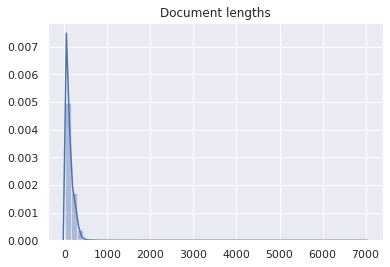

In [28]:
sequences = tokenizer.texts_to_sequences(docs)
sequence_lengths = [len(s) for s in sequences]
if n_sequence is None:
    n_sequence = max(sequence_lengths)
sequences = pad_sequences(sequences, maxlen=n_sequence, padding="post", truncating="post")

print(n_sequence)
print(sequences.shape)
print(sequences[2])

sns.distplot(sequence_lengths)
plt.title("Document lengths")
plt.show()

### As document-term matrix

In [8]:
# doc_term_matrix = tokenizer.texts_to_matrix(docs, mode="tfidf")

# print(doc_term_matrix.shape)
# print(doc_term_matrix[2])

## Word embeddings

In [9]:
n_embedding = 256

### Word2Vec

In [10]:
reset_seed()

window = 5
w2v_path = f"data/w2v_{window}_{n_embedding}.model"

try:
    embedding_model = Word2Vec.load(w2v_path)
except:
    embedding_model = Word2Vec(sentences=[s.split() for s in docs],
                               size=n_embedding, 
                               window=window,
                               min_count=5,
                               sg=1,
                               workers=cpu_count(),
                               seed=seed)
    embedding_model.save(w2v_path)

print(len(list(embedding_model.wv.vocab)))

160759


### Creating embedding matrix

In [11]:
embedding_matrix = np.zeros((n_vocabulary, n_embedding))
for token, i in word_idx.items():
    if i >= n_vocabulary:
        continue
    if token in embedding_model:
        embedding_matrix[i] = embedding_model[token]
    else:
        embedding_matrix[i] = np.zeros(n_embedding)

print(embedding_matrix.shape)
print(embedding_matrix[1])

(5000, 256)
[ 0.17539258 -0.06530272  0.01657451 -0.04425292  0.04128651 -0.18300489
 -0.16919801  0.0480488  -0.09133328  0.02587506 -0.01967425  0.09945878
 -0.05600481 -0.01685121 -0.03599447 -0.14082797 -0.01086318 -0.07289494
  0.0402003  -0.04027929  0.18171482 -0.04842717  0.03684806 -0.0510481
  0.20940183 -0.09696906 -0.08415043  0.0408814  -0.1309191  -0.13459311
  0.46689954 -0.18623862  0.05366851 -0.05996224 -0.13319956 -0.24100822
  0.05342331  0.14736585 -0.25805563  0.31074879 -0.32781357 -0.07095104
 -0.28958547  0.1536327   0.02000534 -0.08507846  0.00419282  0.01348357
  0.06239876  0.19682285  0.19862361  0.06192612 -0.26880991  0.2868703
 -0.0284104   0.15227671 -0.22509414 -0.03397212  0.19979669 -0.04593811
  0.1099792   0.01548944  0.16921869 -0.05802288 -0.32499835 -0.22160961
  0.05431951 -0.05393629 -0.12470939 -0.03527912 -0.13933805 -0.10993122
 -0.01807112  0.18888257  0.37824026 -0.01249813 -0.03216061  0.16550902
 -0.11490405 -0.01706733 -0.0514022   0.1

## Defining the NN model

In [21]:
def init_model():
    model = Sequential()
    
#     model.add(Embedding(input_dim=n_vocabulary, output_dim=n_embedding, input_length=n_sequence))
    model.add(Embedding(
        input_dim=n_vocabulary,
        output_dim=n_embedding,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=n_sequence,
        trainable=False
    ))

    model.add(Dropout(.25))
    model.add(Conv1D(64, 5, activation="relu"))
    model.add(Dropout(.25))
    model.add(Conv1D(128, 5, activation="relu"))
    model.add(Dropout(.25))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(.25))
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(.25))
    
#     model.add(GRU(128, dropout=.2))

#     model.add(Dropout(.25))
#     model.add(Conv1D(64, 5, activation="relu"))
#     model.add(Dropout(.25))
#     model.add(Conv1D(128, 5, activation="relu"))
#     model.add(Dropout(.25))
#     model.add(Flatten())
#     model.add(Dense(128))
#     model.add(BatchNormalization())
#     model.add(ReLU())
#     model.add(Dropout(.25))
#     model.add(Dense(128))
#     model.add(BatchNormalization())
#     model.add(ReLU())
#     model.add(Dropout(.25))

#     model.add(Bidirectional(LSTM(256, return_sequences=True)))
#     model.add(Bidirectional(LSTM(128)))
#     model.add(Dense(128, activation="relu"))
#     model.add(Dropout(.5))

#     model.add(Dense(512, activation="relu", input_shape=(n_vocabulary,)))
#     model.add(Dropout(.5))

#     model.add(Conv1D(100, 4, activation="relu"))
#     model.add(MaxPooling1D(pool_size=3))
#     model.add(Conv1D(100, 2, activation="relu"))
#     model.add(Dropout(.5))
#     model.add(Flatten())
#     model.add(Dense(300, activation="relu"))
    
    model.add(Dense(n_labels, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam")
    
    return model

init_model().summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 64, 256)           1280000   
_________________________________________________________________
dropout_30 (Dropout)         (None, 64, 256)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 60, 64)            81984     
_________________________________________________________________
dropout_31 (Dropout)         (None, 60, 64)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 56, 128)           41088     
_________________________________________________________________
dropout_32 (Dropout)         (None, 56, 128)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 7168)             

## Preparing the data

In [22]:
n_samples = None
x_train, y_train = shuffle(sequences, train_labels, random_state=seed, n_samples=n_samples)

## Cross-evaluating the model

In [23]:
reset_seed()

kfold = KFold(n_splits=5)
cv_scores = []
batch_size = 128

for train, val in kfold.split(x_train, y_train):
    model = init_model()
    es = EarlyStopping(patience=3, verbose=1, restore_best_weights=True)
    history = model.fit(x_train[train],
                        y_train[train],
                        batch_size=batch_size,
                        epochs=100,
                        verbose=1,
                        validation_data=(x_train[val], y_train[val]),
                        callbacks=[es])
    
    y_pred_prob = model.predict(x_train[val], batch_size=batch_size, verbose=1)
    y_pred = np.round(y_pred_prob)
    
    scores = {}
    scores["accuracy"] = accuracy_score(y_train[val], y_pred)
    scores["F1 (macro)"] = f1_score(y_train[val], y_pred, average="macro")
    scores["F1 (micro)"] = f1_score(y_train[val], y_pred, average="micro")
    scores["LRAP"] = label_ranking_average_precision_score(y_train[val], y_pred_prob)
    scores["NDCG"] = ndcg_score(y_train[val], y_pred_prob)
    cv_scores.append(scores)
    print(scores)
    
cv_scores_df = pd.DataFrame(cv_scores)

Epoch 1/100
1874/1874 [==============================] - 19s 10ms/step - loss: 0.0490 - val_loss: 0.0246
Epoch 2/100
1874/1874 [==============================] - 19s 10ms/step - loss: 0.0261 - val_loss: 0.0211
Epoch 3/100
1874/1874 [==============================] - 19s 10ms/step - loss: 0.0238 - val_loss: 0.0199
Epoch 4/100
1874/1874 [==============================] - 19s 10ms/step - loss: 0.0227 - val_loss: 0.0196
Epoch 5/100
1874/1874 [==============================] - 19s 10ms/step - loss: 0.0219 - val_loss: 0.0190
Epoch 6/100
1874/1874 [==============================] - 19s 10ms/step - loss: 0.0214 - val_loss: 0.0186
Epoch 7/100
1874/1874 [==============================] - 19s 10ms/step - loss: 0.0210 - val_loss: 0.0185
Epoch 8/100
1874/1874 [==============================] - 19s 10ms/step - loss: 0.0207 - val_loss: 0.0185
Epoch 9/100
1874/1874 [==============================] - 19s 10ms/step - loss: 0.0205 - val_loss: 0.0182
Epoch 10/100
1874/1874 [==============================]

1874/1874 [==============================] - 19s 10ms/step - loss: 0.0190 - val_loss: 0.0175
Epoch 00020: early stopping
469/469 [==============================] - 2s 4ms/step
{'accuracy': 0.6645817696605788, 'F1 (macro)': 0.5177131605124335, 'F1 (micro)': 0.8759829500514251, 'LRAP': 0.9470441251769898, 'NDCG': 0.9699883856895896}
Epoch 1/100
1874/1874 [==============================] - 19s 10ms/step - loss: 0.0492 - val_loss: 0.0242
Epoch 2/100
1874/1874 [==============================] - 19s 10ms/step - loss: 0.0261 - val_loss: 0.0210
Epoch 3/100
1874/1874 [==============================] - 19s 10ms/step - loss: 0.0238 - val_loss: 0.0200
Epoch 4/100
1874/1874 [==============================] - 19s 10ms/step - loss: 0.0226 - val_loss: 0.0194
Epoch 5/100
1874/1874 [==============================] - 20s 11ms/step - loss: 0.0219 - val_loss: 0.0189
Epoch 6/100
1874/1874 [==============================] - 19s 10ms/step - loss: 0.0214 - val_loss: 0.0186
Epoch 7/100
1874/1874 [==============

## Metrics and their means

In [24]:
display(cv_scores_df)
print(cv_scores_df.mean())

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG
0,0.666416,0.518673,0.876643,0.947233,0.969945
1,0.664248,0.518126,0.875929,0.946046,0.969163
2,0.664582,0.517713,0.875983,0.947044,0.969988
3,0.658939,0.508765,0.872641,0.944521,0.968495
4,0.661724,0.526066,0.876336,0.946134,0.969578


accuracy      0.663182
F1 (macro)    0.517869
F1 (micro)    0.875506
LRAP          0.946196
NDCG          0.969434
dtype: float64
